In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scdna_replication_tools.plot_utils import get_cna_cmap, get_clone_cmap, plot_cell_cn_profile2

In [2]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

despine_offset = 10
despine_trim = True

### Load and plot the clone RT profiles for SA1292

In [3]:
# load pseudobulk RT profiles
rt_SA1292 = pd.read_csv('scdna_replication_paper/analysis/sig_lines/SA1292/scRT_pseudobulks.tsv', sep='\t')
cn_s = pd.read_csv('scdna_replication_paper/analysis/sig_lines/SA1292/s_phase_cells_with_scRT_filtered.tsv', sep='\t', usecols=['chr', 'start', 'end', 'gc'])
cn_s = cn_s.drop_duplicates()

rt_SA1292 = pd.merge(rt_SA1292, cn_s)
rt_SA1292.chr = rt_SA1292.chr.astype('str').astype('category')

In [4]:
def plot_rel_clone_rt_profiles(rt, ax):
    rep_col = 'model_rep_state'
    cols = [x for x in rt.columns if x.startswith('pseudobulk_clone') and x.endswith(rep_col)]
    clones = [x.split('_')[1].replace('clone', '') for x in cols]
    ref_clone = clones[0]

    clone_cmap = get_clone_cmap()

    for clone_id, col in zip(clones, cols):
        # compute distance between this clone's RT and the reference clone (A)
        if clone_id != ref_clone:
            rt['temp_diff_rt'] = rt[col] - rt['pseudobulk_clone{}_{}'.format(ref_clone, rep_col)]

            # plot the whole genome
            plot_cell_cn_profile2(
                ax, rt, 'temp_diff_rt', color=clone_cmap[clone_id], rawy=True, s=0.5,
                max_cn=None, scale_data=False, lines=True, label=clone_id, rasterized=True
            )

    ax.set_title('RT shifts at subclonal CNAs in SA1292')
    ax.legend(title='clone ID')
    ax.set_ylabel('RT relative to clone {}\n<--clone later | clone earlier-->'.format(ref_clone))

### Load and plot data showing the RT shifts at subclonal CNAs for all hTERTs

In [5]:
rt_diff = pd.read_csv('scdna_replication_paper/analysis/sig_lines/subclonal_rt_diffs_summary.tsv', sep='\t')

# create a new column titled reference_rt_tens which shows the reference RT within each 0.1 bin of RT
rt_diff['reference_rt_tens'] = rt_diff.reference_rt.apply(lambda x: int(x*10))
# reset reference_rt_tens to 9 if it is 10
rt_diff['reference_rt_tens'] = np.where(rt_diff.reference_rt_tens == 10, 9, rt_diff.reference_rt_tens)

rt_diff.head()

,chr,start,end,reference_rt,clone_rt,clone_rt_diff,clone_cna_type,dataset,reference_rt_tens
0,11,66000001,66500000,0.991187,0.972,-0.019187,gain,SA039,9
1,11,66500001,67000000,0.990740,0.994,0.003260,gain,SA039,9
2,11,67000001,67500000,0.990190,0.992,0.001810,gain,SA039,9
3,11,67500001,68000000,0.967987,0.980,0.012013,gain,SA039,9
4,11,68000001,68500000,0.959226,0.972,0.012774,gain,SA039,9


In [6]:
def plot_subclonal_rt_shifts_per_rt(df, ax):
    ''' Plot the distribution of RT shifts at subclonal CNAs, stratified by reference RT '''
    sns.boxplot(
        data=df, x='reference_rt_tens', y='clone_rt_diff', hue='clone_cna_type', hue_order=['loss', 'unaltered', 'gain'], 
        palette=get_cna_cmap(), ax=ax, linewidth=0.5, fliersize=0.5
    )
    ax.set_xlabel('reference RT\n<--late | early-->')
    ax.set_ylabel('clone RT relative to reference\n<--later | earlier-->')
    ax.legend(title='subclonal CNA type', loc='lower left')
    ax.set_title('RT shifts at subclonal CNAs - all hTERTs')
    # set the x-tick labels to show the range of actual RT values for each tick
    # i.e. 0.0-0.1, 0.1-0.2, etc.
    ax.set_xticklabels(['0.0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1.0'])

    # ax.set_ylim(-0.5, 0.5)

    # loop through reference_rt_tens values and add significance bars betwen loss-unaltered and gain-unaltered
    for i in range(0, 10):
        # get the data for this reference_rt_tens
        temp_df = df[df.reference_rt_tens == i]
        # get the y-values for the loss-unaltered and gain-unaltered comparisons
        loss = temp_df[temp_df.clone_cna_type == 'loss'].clone_rt_diff
        unaltered = temp_df[temp_df.clone_cna_type == 'unaltered'].clone_rt_diff
        gain = temp_df[temp_df.clone_cna_type == 'gain'].clone_rt_diff
        # compute the p-value between loss-unaltered and gain-unaltered
        loss_unaltered_pval = stats.ttest_ind(loss, unaltered)[1]
        gain_unaltered_pval = stats.ttest_ind(gain, unaltered)[1]
        # add the significance bars, one star if p < 0.05, two stars if p < 0.01, three stars if p < 0.001
        if loss_unaltered_pval < 0.001:
            ax.text(i-0.1, 0.8, '***', color=get_cna_cmap()['loss'], ha='center', va='center')
        elif loss_unaltered_pval < 0.01:
            ax.text(i-0.1, 0.8, '**', color=get_cna_cmap()['loss'], ha='center', va='center')
        elif loss_unaltered_pval < 0.05:
            ax.text(i-0.1, 0.8, '*', color=get_cna_cmap()['loss'], ha='center', va='center')
        if gain_unaltered_pval < 0.001:
            ax.text(i+0.1, 0.75, '***', color=get_cna_cmap()['gain'], ha='center', va='center')
        elif gain_unaltered_pval < 0.01:
            ax.text(i+0.1, 0.75, '**', color=get_cna_cmap()['gain'], ha='center', va='center')
        elif gain_unaltered_pval < 0.05:
            ax.text(i+0.1, 0.75, '*', color=get_cna_cmap()['gain'], ha='center', va='center')
        
    sns.despine(ax=ax, offset=despine_offset, trim=despine_trim)

### Instead of looking at the RT distribution shift as a function of reference RT, look at the distribution within each unique CNA

In [7]:
# assume that there is only one CNA per unique combination of chr, dataset, and clone_cna_type
unique_events = rt_diff[['chr', 'dataset', 'clone_cna_type']].drop_duplicates().reset_index(drop=True)

# loop through each unique event and plot the relationship between reference_rt and clone_rt_diff
unique_events['mean_rt_diff'] = np.nan
unique_events['median_rt_diff'] = np.nan
unique_events['std_rt_diff'] = np.nan
unique_events['event_size'] = np.nan
for i, row in unique_events.iterrows():
    temp_df = rt_diff[(rt_diff.chr == row.chr) & (rt_diff.dataset == row.dataset) & (rt_diff.clone_cna_type == row.clone_cna_type)]
    # compute the mean, median, and std of clone_rt_diff for this event, and add them to the unique_events df
    unique_events.loc[i, 'mean_rt_diff'] = temp_df.clone_rt_diff.mean()
    unique_events.loc[i, 'median_rt_diff'] = temp_df.clone_rt_diff.median()
    unique_events.loc[i, 'std_rt_diff'] = temp_df.clone_rt_diff.std()
    # the bin size is the number of loci in this event x 500kb
    unique_events.loc[i, 'event_size'] = temp_df.shape[0] * 500000

unique_events.head()

,chr,dataset,clone_cna_type,mean_rt_diff,median_rt_diff,std_rt_diff,event_size
0,11,SA039,gain,0.020610,0.017963,0.031334,66500000.0
1,20,SA039,gain,-0.018443,-0.017174,0.042669,57000000.0
2,22,SA039,loss,0.028696,0.013244,0.036376,8000000.0
3,8,SA039,loss,0.034678,0.033063,0.058613,42000000.0
4,8,SA039,gain,-0.041448,-0.033308,0.076753,96500000.0


In [8]:
def plot_subclonal_rt_shifts_per_event(df, ax):
    # plot the histogram of mean_rt_diff with a hue of clone_cna_type
    sns.histplot(
        data=df, x='mean_rt_diff', hue='clone_cna_type', hue_order=['loss', 'unaltered', 'gain'], 
        palette=get_cna_cmap(), common_norm=False, stat='density', ax=ax, kde=True, cbar_kws={'edgecolor': 'k', 'linewidth': 0}
    )

    ax.set_xlabel('mean RT shift per CNA\n<--later | earlier-->')
    ax.set_title('RT shifts at subclonal CNAs - all hTERTs')

    # compute the p-values between loss-unaltered and gain-unaltered
    # get the y-values for the loss-unaltered and gain-unaltered comparisons
    loss = df[df.clone_cna_type == 'loss'].mean_rt_diff
    unaltered = df[df.clone_cna_type == 'unaltered'].mean_rt_diff
    gain = df[df.clone_cna_type == 'gain'].mean_rt_diff
    # compute the p-value between loss-unaltered and gain-unaltered
    # multiply by 3 because we are doing 3 tests (bonferroni correction)
    loss_unaltered_pval = stats.ttest_ind(loss, unaltered)[1] * 3
    gain_unaltered_pval = stats.ttest_ind(gain, unaltered)[1] * 3
    gain_loss_pval = stats.ttest_ind(gain, loss)[1] * 3

    # annotate the p-values in the upper-left corner
    ax.text(0.05, 0.9, 'gain-unalt p={:.1e}'.format(gain_unaltered_pval), transform=ax.transAxes, ha='left', va='center')
    ax.text(0.05, 0.8, 'gain-loss p={:.1e}'.format(gain_loss_pval), transform=ax.transAxes, ha='left', va='center')
    ax.text(0.05, 0.7, 'loss-unalt p={:.1e}'.format(loss_unaltered_pval), transform=ax.transAxes, ha='left', va='center')

    # remove the legned
    ax.legend_.remove()

    sns.despine(ax=ax, offset=despine_offset, trim=despine_trim)


### Load and plot data showing RNA buffering of CNAs using TreeAlign results

In [9]:
# list of datasets with both scDNA and scRNA data
rna_datasets = ['SA039', 'SA906b', 'SA1188', 'SA1054', 'SA1055']

# read in the rna buffering clone_cn_expr tables that hongyu generated
buff_df = []
for d in rna_datasets:
    temp_df = pd.read_csv('scdna_replication_paper/data/signatures/rna_buffering/clone_cn_expr_{}.csv'.format(d))
    temp_df['dataset'] = d
    buff_df.append(temp_df)
buff_df = pd.concat(buff_df, ignore_index=True)

# subset buff_df to just rows that have metric==median_state
buff_df = buff_df[buff_df['metric']=='median_state']

# drop the metric column, and rename 'value' column to 'median_state'
buff_df = buff_df.drop(columns=['metric'])
buff_df = buff_df.rename(columns={'value': 'median_state'})

# convert median_state to int
buff_df['median_state'] = buff_df['median_state'].astype(int)
buff_df.head()

,gene,clone_id,median_state,mean_normalized_expression,normalized_expression_per_copy,dataset
0,A1BG,node_1,2,0.001773,0.000887,SA039
7,A1BG,node_1092,2,0.004215,0.002108,SA039
8,A1BG,node_653,2,0.000000,0.000000,SA039
14,A1BG,node_688,2,0.002105,0.001053,SA039
19,A1BG-AS1,node_1,2,0.006206,0.003103,SA039


In [10]:
def plot_box_with_pval(df, ax):
    cn_cdict = {0:'#3182BD', 1:'#9ECAE1', 2:'#CCCCCC', 3:'#FDCC8A', 4:'#FC8D59', 5:'#E34A33', 6:'#B30000', 7:'#980043', 8:'#DD1C77', 9:'#DF65B0', 10:'#C994C7', 11:'#D4B9DA'}
    sns.boxplot(x='median_state', y='normalized_expression_per_copy', data=df, palette=cn_cdict, ax=ax, linewidth=0.5, fliersize=0.5)
    ax.set_yscale('log')
    ax.set_xlabel('median CN state')
    ax.set_ylabel('expression per copy')
    # compute the kruskal-wallis test
    kruskal_wallis = stats.kruskal(*[df[df['median_state']==state]['normalized_expression_per_copy'].values for state in df.median_state.unique()])
    ax.text(0.9, 0.9, 'Kruskal-Wallis\np={:.2e}'.format(kruskal_wallis.pvalue), transform=ax.transAxes, ha='right', va='center')
    sns.despine(ax=ax, offset=despine_offset, trim=despine_trim)


def plot_rna_buffering(df, datasets, ax0, ax1, ax2, ax3, ax4, ax5):
    for ax, d in zip([ax0, ax1, ax2, ax3, ax4], datasets):
        temp_df = df[df['dataset']==d]
        plot_box_with_pval(temp_df, ax)
        if ax == ax1:
            ax.set_title('RNA buffering of CNAs in hTERTs\n{}'.format(d))
        else:
            ax.set_title(d)

    # plot across the whole cohort in the final subplot
    plot_box_with_pval(df, ax5)
    ax5.set_title('All available hTERTs')


/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


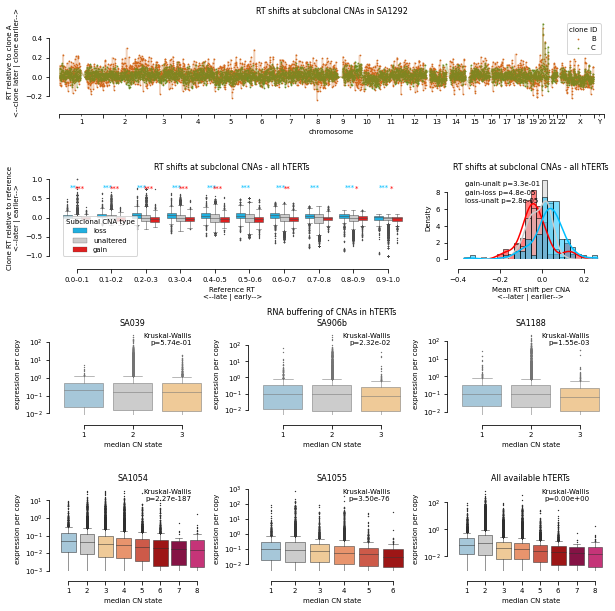

In [13]:
# create figure
fig, ax = plt.subplots(4, 3, figsize=(8.5, 8.5), tight_layout=True)

# merge the all subplots in the first row
ax[0, 0].remove()
ax[0, 1].remove()
ax[0, 2].remove()
ax[0, 0] = fig.add_subplot(4, 3, (1, 3))

# merge the left two subplots in the 2nd row
ax[1, 0].remove()
ax[1, 1].remove()
ax[1, 0] = fig.add_subplot(4, 3, (4, 5))

chrom_labels_to_remove = ['21']

# plot the relative RT profiles for SA1292 clones
plot_rel_clone_rt_profiles(rt_SA1292, ax[0, 0])

# plot the RT shifts at subclonal CNAs, stratified by reference RT
plot_subclonal_rt_shifts_per_rt(rt_diff, ax[1, 0])

# plot the RT shifts at subclonal CNAs per event
plot_subclonal_rt_shifts_per_event(unique_events, ax[1, 2])

# plot the RNA buffering of CNAs in hTERTs
plot_rna_buffering(buff_df, rna_datasets, ax[2, 0], ax[2, 1], ax[2, 2], ax[3, 0], ax[3, 1], ax[3, 2])

# draw a dashed lines around the boundaries of the entire figure to know where to crop
# ax_bottom = fig.add_axes([0, 0, 1, 0.01])
# ax_top = fig.add_axes([0, 0.99, 1, 0.01])
# ax_left = fig.add_axes([0, 0, 0.01, 1])
# ax_right = fig.add_axes([0.99, 0, 0.01, 1])
# for ax in [ax_bottom, ax_top, ax_left, ax_right]:
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])

fig.savefig('scdna_replication_paper/manuscript/extended_data_figs/figED4.pdf', dpi=300, bbox_inches='tight')

plt.show()